In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests
import time
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Создание графа и выделение крупнейшей связной компоненты

In [32]:
edges = pd.read_csv("data/inf-euroroad.edges", delimiter=' ', header=1).iloc[:, :2]
edges.columns = ['source', 'target']

G = nx.from_pandas_edgelist(edges,
                            source='source',
                            target='target')

largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

print(f"Количество узлов: {G_largest.number_of_nodes()}")
print(f"Количество ребер: {G_largest.number_of_edges()}")

Количество узлов: 1039
Количество ребер: 1305


# Визуализация графа

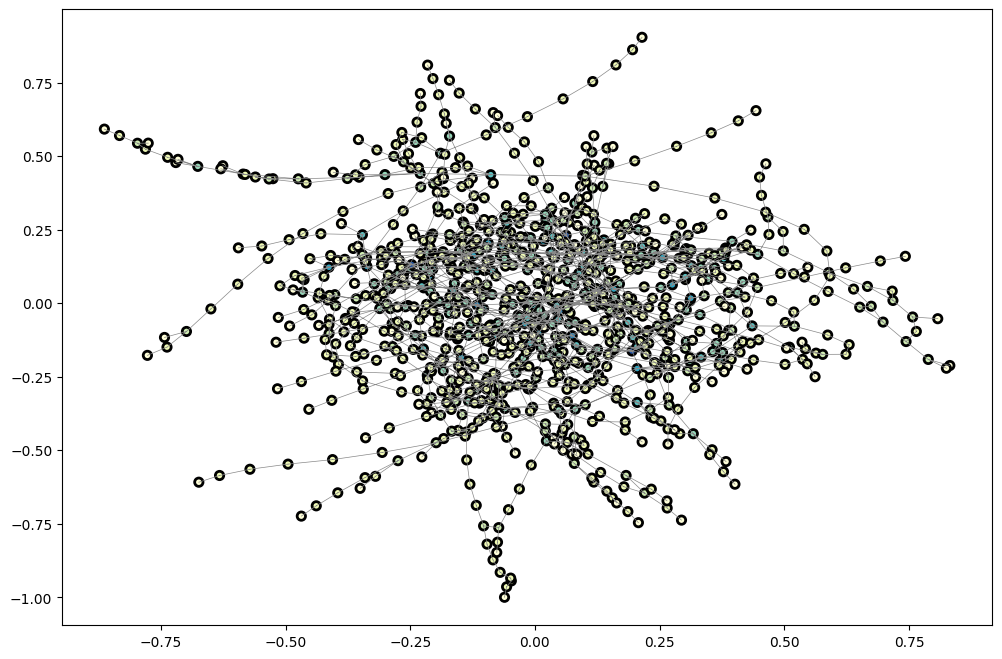

In [33]:
# Устанавливаем позиции узлов с использованием алгоритма пружинной разметки
pos = nx.spring_layout(G_largest)

# Извлекаем позиции узлов
node_x = []
node_y = []
for node in G_largest.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Создаем ребра
edge_x = []
edge_y = []
for edge in G_largest.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # Для отображения раздельных линий между ребрами
    edge_y.extend([y0, y1, None])  # Для отображения раздельных линий между ребрами

# Создаем фигуру с увеличенным размером
fig, ax = plt.subplots(figsize=(12, 8))  # Увеличиваем размер фигуры до 12x8 дюймов

# Создаем узлы
ax.scatter(node_x, node_y, s=10, c=[], edgecolors='black', linewidths=2)

# Определяем цвет узлов в зависимости от количества связей
node_adjacencies = [len(list(G_largest.neighbors(node))) for node in G_largest.nodes()]
ax.scatter(node_x, node_y, c=node_adjacencies, cmap='YlGnBu', edgecolors='black', linewidths=2)

# Создаем линии ребер
ax.plot(edge_x, edge_y, color='#888', linewidth=0.5)


# Отображаем фигуру
plt.show()

# Кластеризация

In [34]:
from networkx.algorithms.community import modularity
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community import asyn_fluidc

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import time 

In [35]:
G = nx.from_pandas_edgelist(edges,
                            source='source',
                            target='target')

largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

print(f"Количество узлов: {G.number_of_nodes()}")
print(f"Количество ребер: {G.number_of_edges()}")

Количество узлов: 1039
Количество ребер: 1305


In [36]:
results = pd.DataFrame({'Метод' : [],
                        'Количество кластеров' : [],
                        'Модулярность' : [],
                        'Коэффициент силуэта' : [],
                        'Индекс Калински-Харабаша' : [],
                        'Индекс Дэвиcа-Боулдина': [],
                        'Время выполнения': []})

# Матрица расстояний

In [37]:
dist_matrix = nx.floyd_warshall_numpy(G)

In [38]:
dist_matrix.shape

(1039, 1039)

## 1) Лувенский алгоритм

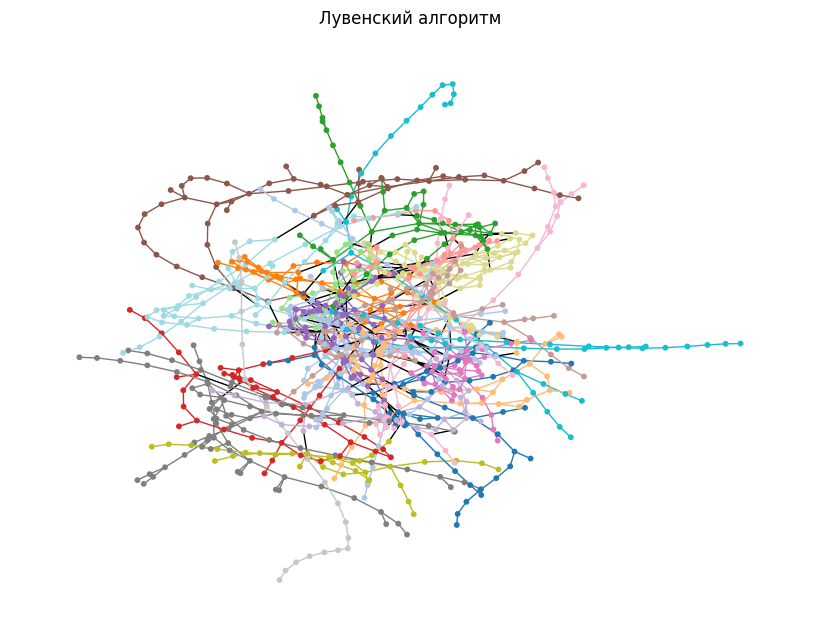

In [39]:
start = time.time()
communities = louvain_communities(G)

colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title(f"Лувенский алгоритм")
plt.show()

end_LA = time.time() - start

In [40]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

In [41]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_LA)

Модулярность: 0.863492021549889
Коэффициент силуэта: 0.13664132363025935
Индекс Калински-Харабаша: 333.9263605016555
Индекс Дэвиcа-Боулдина: 1.65999149268374
Время выполнения 3.402665138244629


In [42]:
results.loc[len(results)] = ['Лувенский алгоритм',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5), 
                             round(end_LA, 5)]

## 2) Алгоритм Гирвана-Ньюмена

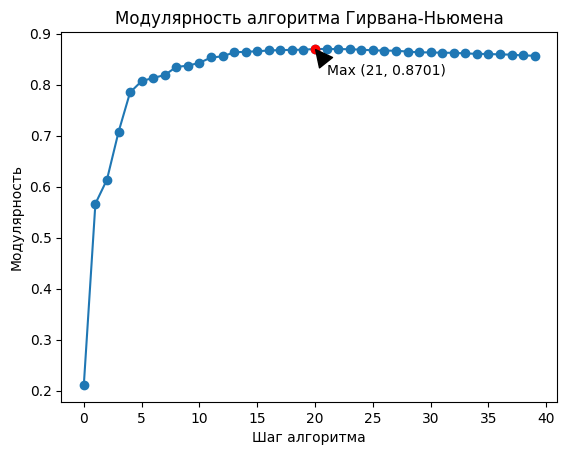

In [43]:
start = time.time()

communities_generator = girvan_newman(G)

modularity_values = []
optimal_communities_gn = []
max_modularity_index = None
counter = 0

for i, communities in enumerate(communities_generator):
    current_modularity = modularity(G, communities)
    modularity_values.append(current_modularity)

    if max_modularity_index is None or current_modularity > modularity_values[max_modularity_index]:
        max_modularity_index = i
        optimal_communities_gn = communities

    counter += 1
    if counter >= 40:
        break

end_GN1 = time.time() - start

plt.plot(modularity_values, marker='o')
plt.xlabel("Шаг алгоритма")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма Гирвана-Ньюмена")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index, modularity_values[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 1}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 1, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

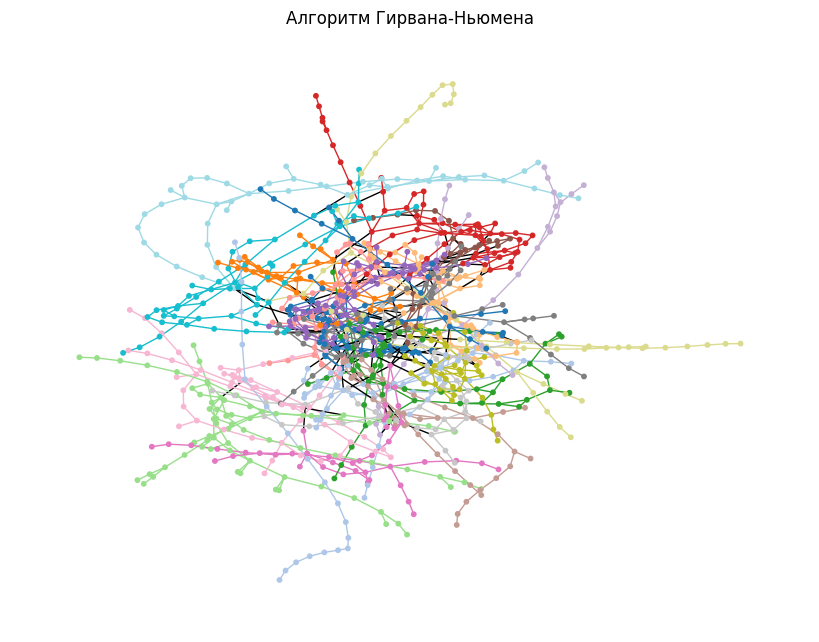

In [44]:
start = time.time()

colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(optimal_communities_gn):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title(f"Алгоритм Гирвана-Ньюмена")
plt.show()

end_GN2 = time.time() - start

In [45]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(optimal_communities_gn):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

In [46]:
modularity_value = modularity(G, optimal_communities_gn)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_GN1+end_GN2)

Модулярность: 0.8700571042703423
Коэффициент силуэта: 0.14086859453101522
Индекс Калински-Харабаша: 364.17061656335375
Индекс Дэвиcа-Боулдина: 1.5549110390551293
Время выполнения 78.16710805892944


In [47]:
results.loc[len(results)] = ['Алгоритм Гирвана-Ньюмена',
                             len(optimal_communities_gn),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_GN1+end_GN2, 5)]

## 3) Жадный алгоритм максимизации модулярности

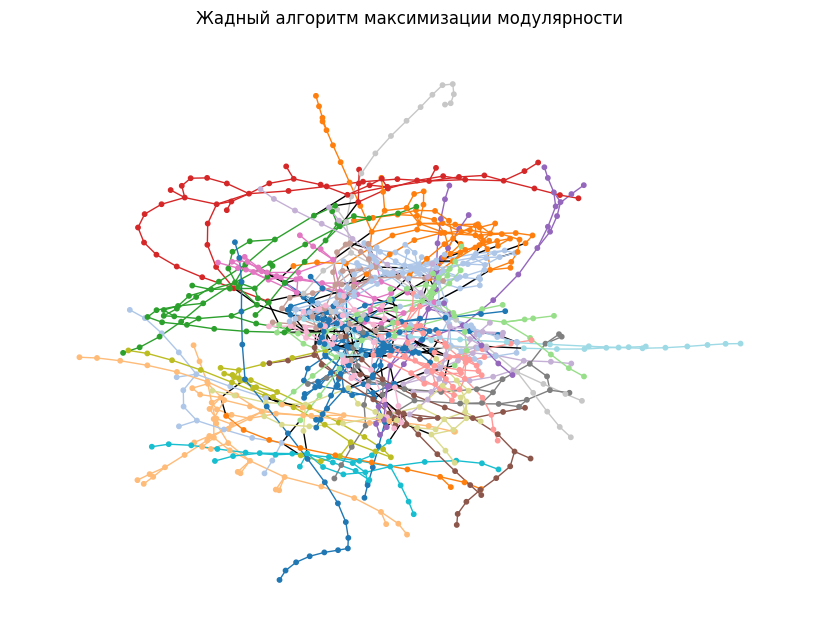

In [48]:
start = time.time()

communities = greedy_modularity_communities(G)

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title("Жадный алгоритм максимизации модулярности")
plt.show()

end_GM = time.time() - start

In [49]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список емток
labels = [node_to_community[node] for node in G.nodes()]

In [50]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_GM)

Модулярность: 0.8605942367258262
Коэффициент силуэта: 0.10107169174775142
Индекс Калински-Харабаша: 345.43594575722557
Индекс Дэвиcа-Боулдина: 2.072799366279168
Время выполнения 3.1026065349578857


In [52]:
results.loc[len(results)] = ['Жадный алгоритм максимизации модулярности',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_GM, 5)]

## 4) Асинхронный метод распространения меток

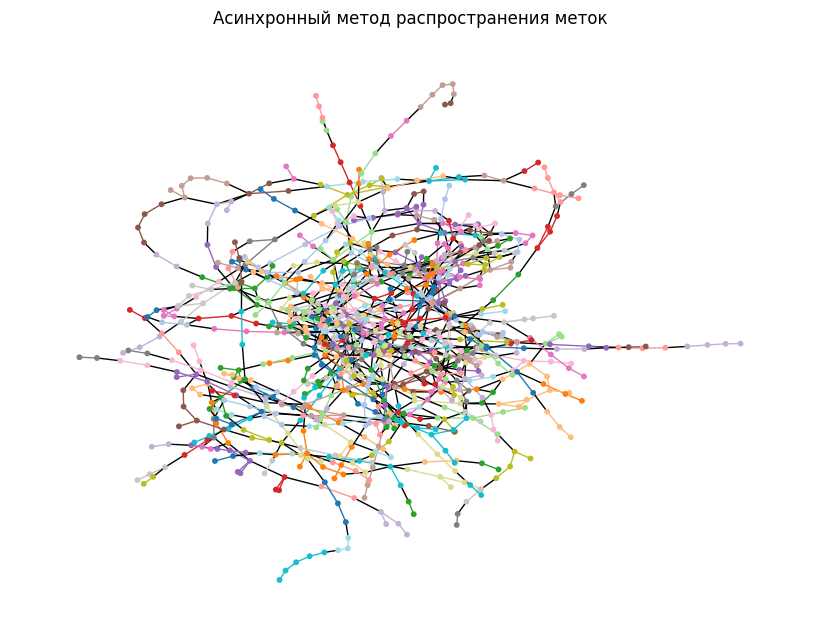

In [53]:
start = time.time()

communities = list(asyn_lpa_communities(G))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title('Асинхронный метод распространения меток')
plt.show()

end_LPA = time.time() - start

In [54]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

In [55]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_LPA)

Модулярность: 0.5506087696892303
Коэффициент силуэта: -0.045356937044802884
Индекс Калински-Харабаша: 232.18098645569845
Индекс Дэвиcа-Боулдина: 1.4842936873333552
Время выполнения 3.3550007343292236


In [56]:
results.loc[len(results)] = ['Асинхронный метод распространения меток',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_LPA, 5)]

## 5) Синхронный метод распространения меток

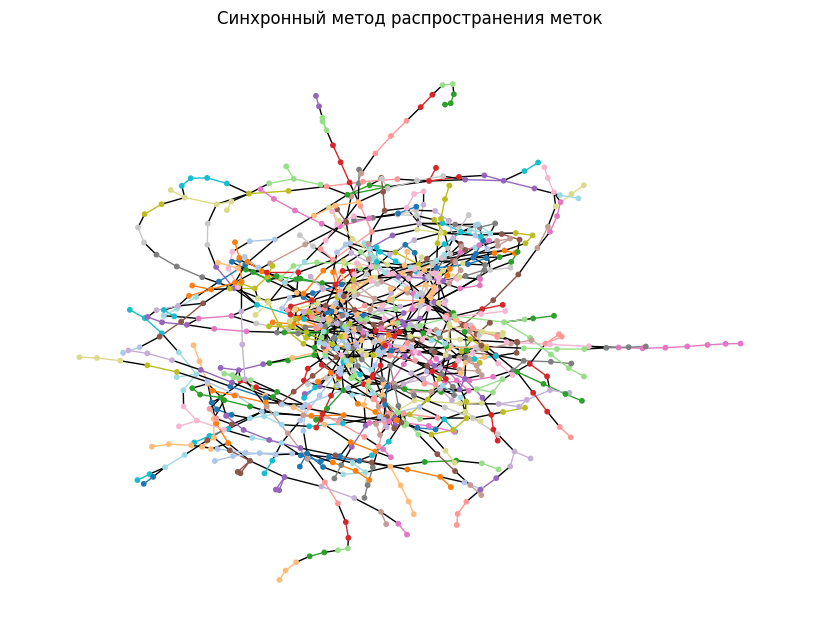

In [57]:
start = time.time()

communities = list(label_propagation_communities(G))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title('Синхронный метод распространения меток')
plt.show()

end_SPA = time.time() - start

In [58]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

In [59]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_SPA)

Модулярность: 0.5446969363338776
Коэффициент силуэта: -0.05675483195267058
Индекс Калински-Харабаша: 223.75164722742275
Индекс Дэвиcа-Боулдина: 1.5826162126705974
Время выполнения 3.1210007667541504


In [60]:
results.loc[len(results)] = ['Синхронный метод распространения меток',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_SPA, 5)]

## 6) Алгоритм асинхронного распределения жидкости

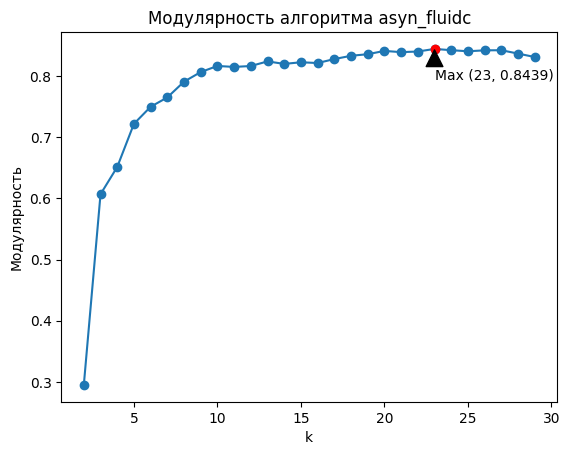

In [61]:
start = time.time()

modularity_values = []
optimal_communities = []
max_modularity_index = None

for k in range(2, 30):
    communities = asyn_fluidc(G, k=k, seed=63)

    modularity_value = modularity(G, communities)
    modularity_values.append(modularity_value)

    if max_modularity_index is None or modularity_value > modularity_values[max_modularity_index]:
        max_modularity_index = k - 2
        optimal_communities = communities

end_AF1 = time.time() - start 

plt.plot(range(2, 30), modularity_values, marker='o')
plt.xlabel("k")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма asyn_fluidc")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_values[max_modularity_index], 'ro')

# Вывод оптимальной точки с аннотацией
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 2, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

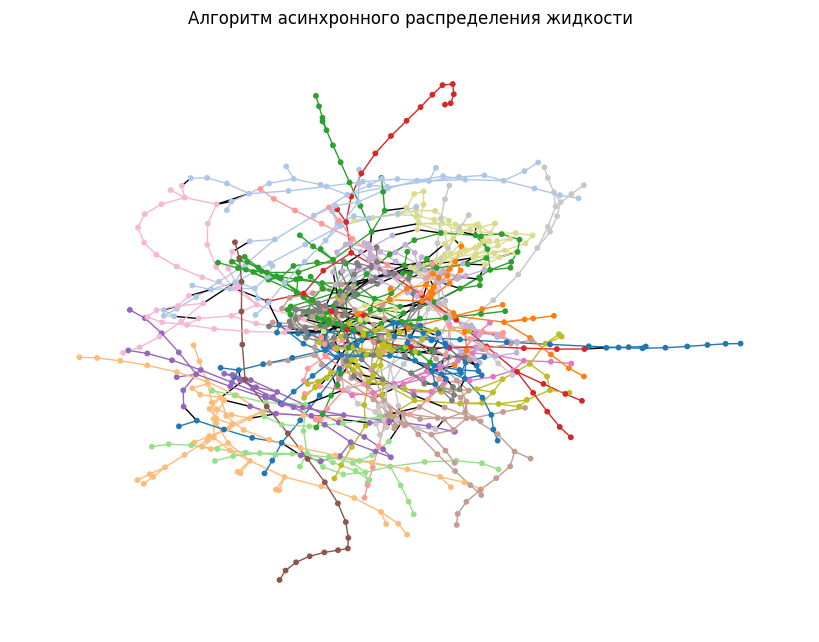

In [62]:
communities = list(asyn_fluidc(G, k=18, seed=63))

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title('Алгоритм асинхронного распределения жидкости')
plt.show()

end_AF2 = time.time() - start 

In [63]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

In [64]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_AF1+end_AF2)

Модулярность: 0.8327173705612071
Коэффициент силуэта: 0.12329957663629149
Индекс Калински-Харабаша: 403.9941452172916
Индекс Дэвиcа-Боулдина: 2.2784620943069873
Время выполнения 8.37636685371399


In [65]:
results.loc[len(results)] = ['Алгоритм асинхронного распределения жидкости',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5), 
                             round(end_AF1+end_AF2, 5)]

## 7) K-Means

### Метод локтя (Elbow Method)

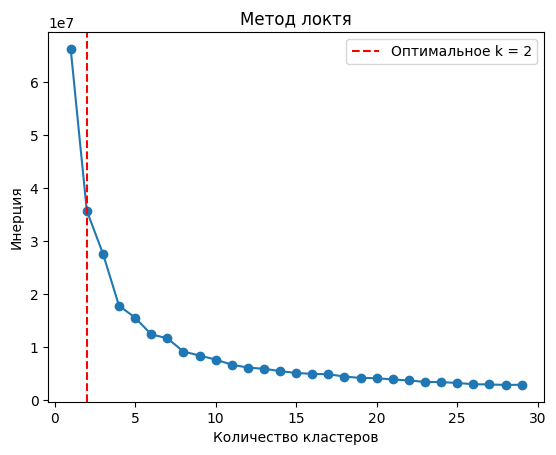

In [66]:
inertias = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dist_matrix)
    inertias.append(kmeans.inertia_)

# Вычисляем первую производную инерции
differences = np.diff(inertias)

# Вычисляем вторую производную инерции
acceleration = np.diff(differences)

# Находим индекс, где вторая производная становится максимальной
optimal_k_index = np.argmax(acceleration) + 1  # добавляем 1, так как разница в длине массива
optimal_k = optimal_k_index + 1  # добавляем 1, так как индексация начинается с 0

# Визуализируем метод локтя
plt.plot(range(1, 30), inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Оптимальное k = {optimal_k}')
plt.legend()
plt.show()

### Индекс силуэта (Silhouette Score)

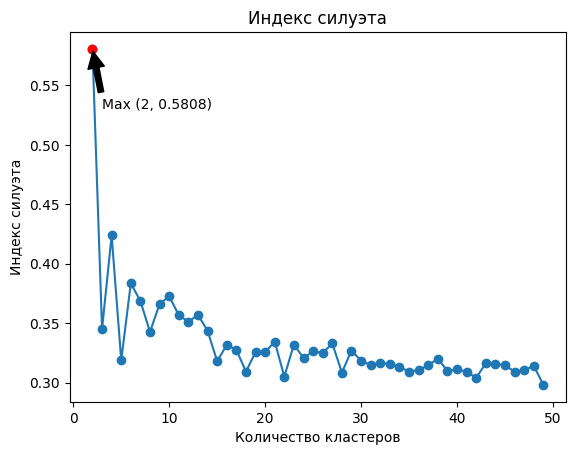

In [68]:
silhouette_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dist_matrix)
    silhouette = silhouette_score(dist_matrix, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.plot(range(2, 50), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс силуэта')
plt.title('Индекс силуэта')

# Находим индекс максимального значения силуэта
max_silhouette_index = silhouette_scores.index(max(silhouette_scores))

# Добавляем красную точку для максимального значения силуэта
plt.plot(max_silhouette_index + 2, silhouette_scores[max_silhouette_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_silhouette_index + 2}, {silhouette_scores[max_silhouette_index]:.4f})',
             xy=(max_silhouette_index + 2, silhouette_scores[max_silhouette_index]),
             xytext=(max_silhouette_index + 3, silhouette_scores[max_silhouette_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Модулярность

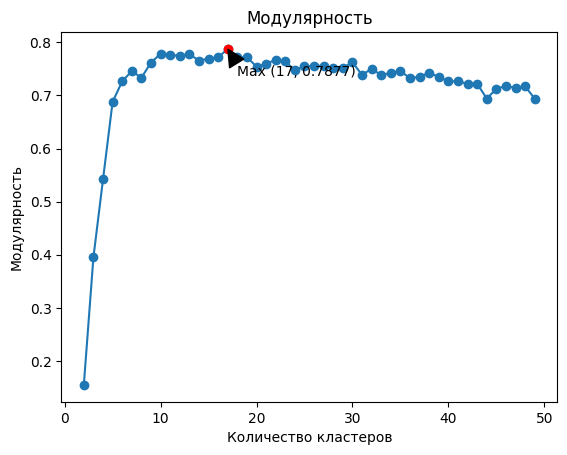

In [69]:
start = time.time()

modularity_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dist_matrix)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

end_KM1 = time.time() - start

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

### Обучение

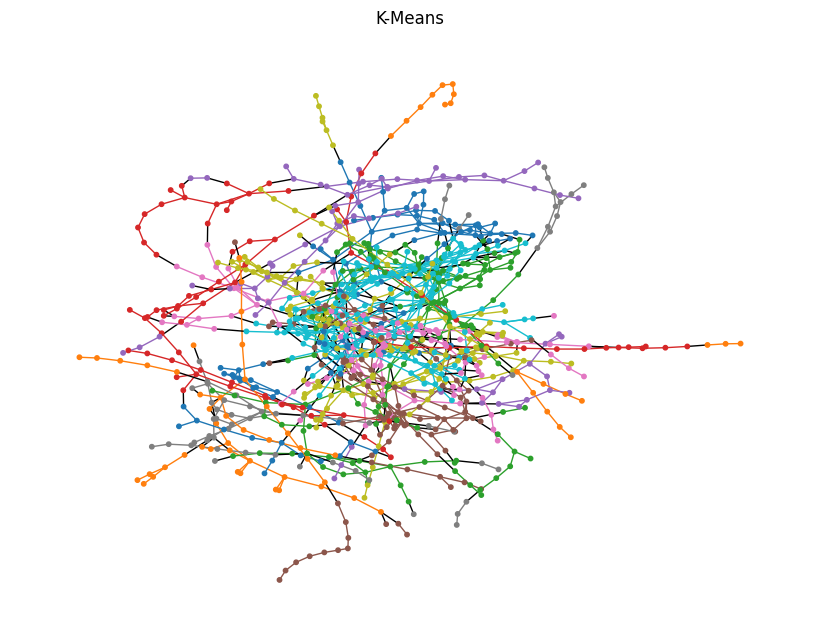

In [70]:
start = time.time()

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(dist_matrix)
labels = kmeans.labels_

colors = plt.cm.tab10.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title('K-Means')
plt.show()

end_KM2 = time.time() - start

In [71]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

In [72]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_KM1+end_KM2)

Модулярность: 0.7574794850339837
Коэффициент силуэта: 0.30993871067183343
Индекс Калински-Харабаша: 819.1334360886715
Индекс Дэвиcа-Боулдина: 0.9745088202278751
Время выполнения 5.635998964309692


In [73]:
results.loc[len(results)] = ['K-Means',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5), 
                             round(end_KM1+end_KM2, 5)]

## 9) Агломеративная кластеризация

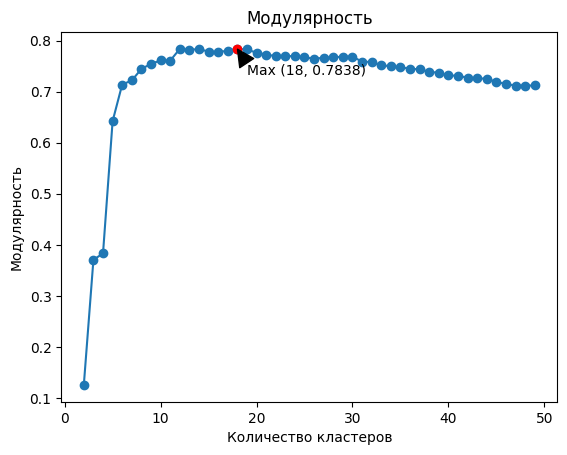

In [78]:
start = time.time()
modularity_scores = []

for k in range(2, 50):
    kmeans = AgglomerativeClustering(n_clusters=k)
    kmeans.fit(dist_matrix)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

end_AC1 = time.time() - start

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

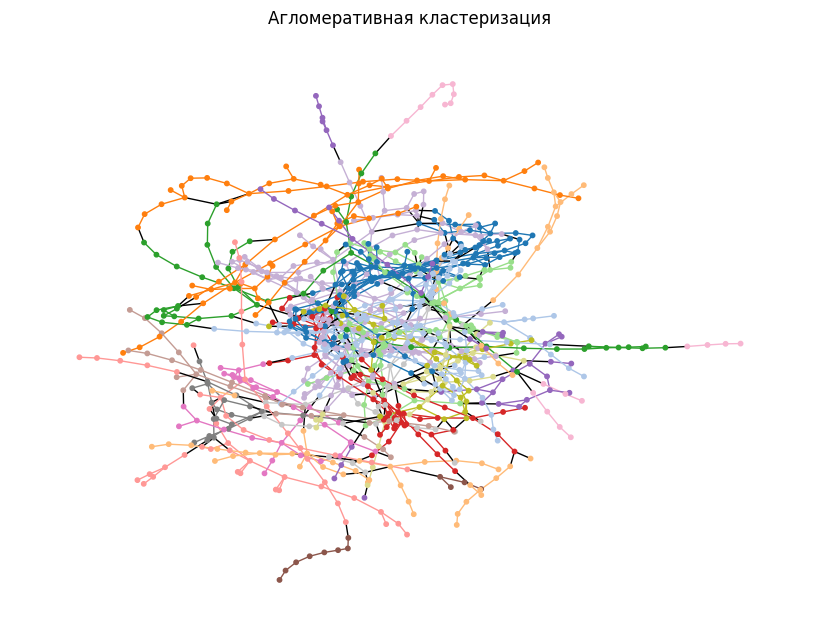

In [79]:
start = time.time()

n_clusters = 18

hclust = AgglomerativeClustering(n_clusters)
labels = hclust.fit_predict(dist_matrix)

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=10)
plt.title('Агломеративная кластеризация')
plt.show()

end_AC2 = time.time() - start

In [80]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

In [81]:
modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(dist_matrix, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(dist_matrix, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(dist_matrix, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_AC1+end_AC2)

Модулярность: 0.7838220225774725
Коэффициент силуэта: 0.29326163308726394
Индекс Калински-Харабаша: 751.2522286575436
Индекс Дэвиcа-Боулдина: 0.9219069486838042
Время выполнения 12.543000221252441


In [82]:
results.loc[len(results)] = ['Агломеративная кластеризация',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_AC1+end_AC2, 5)]

# Результаты

In [83]:
results.sort_values(by='Модулярность', ascending=False)

,Метод,Количество кластеров,Модулярность,Коэффициент силуэта,Индекс Калински-Харабаша,Индекс Дэвиcа-Боулдина,Время выполнения
1,Алгоритм Гирвана-Ньюмена,22,0.87006,0.14087,364.17062,1.55491,78.16711
0,Лувенский алгоритм,22,0.86349,0.13664,333.92636,1.65999,3.40267
2,Жадный алгоритм максимизации модулярности,23,0.86059,0.10107,345.43595,2.07280,3.10261
5,Алгоритм асинхронного распределения жидкости,18,0.83272,0.12330,403.99415,2.27846,8.37637
7,Агломеративная кластеризация,18,0.78382,0.29326,751.25223,0.92191,12.54300
6,K-Means,20,0.75748,0.30994,819.13344,0.97451,5.63600
3,Асинхронный метод распространения меток,342,0.55061,-0.04536,232.18099,1.48429,3.35500
4,Синхронный метод распространения меток,354,0.54470,-0.05675,223.75165,1.58262,3.12100
